In [1]:
import numpy as np
import torch as ch
from pathlib import Path
from unlearning.auditors.utils import (
    loader_factory,
 )
import yaml
import numpy as np
import torch as ch
import matplotlib.pyplot as plt
from pathlib import Path

from unlearning.auditors.utils import (
    loader_factory)
from unlearning.auditors import ulira

ULIRA_BASE_DIR = Path(
    "/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA/"
)
if not ULIRA_BASE_DIR.exists():
    ULIRA_BASE_DIR = Path("/mnt/xfs/projects/untrak/MATCHING/ULIRA/")

def read_yaml(yaml_file):
    with open(yaml_file, "r") as f:
        config = yaml.safe_load(f)
    return config


def load_model(path, model_factory, ds_name):
    model = model_factory(ds_name)
    loaded_model = ch.load(path)
    first_key = list(loaded_model.keys())[0]
    if "model" in first_key:
        model.load_state_dict(loaded_model)

    else:
        # add ".model" to each key in k,vs
        loaded_model = {f"model.{k}": v for k, v in loaded_model.items()}
        model.load_state_dict(loaded_model)
    return model



/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ULIRA_BASE_DIR

PosixPath('/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA')

In [3]:
# compute margins from the logits

# ORACLE MODEL margin computation
dataset_name = "CIFAR10"
train_f = ULIRA_BASE_DIR / dataset_name# / "train_margins_all.pt"
val_f = ULIRA_BASE_DIR / dataset_name #/ "val_margins_all.pt"

def sort_key(x):
    return int(x.name.split("_")[-1][:-len(".pt")])
set_name = "train"

#train_f = ULIRA_BASE_DIR / "CIFAR10____benchmark_GD_wrapper__dataset=CIFAR10__num_epochs=5__learning_rate=0.001__forget_batch_size=64" / "ulira"
# get the oracles
if False:

    for set_name in ["train", "val"]:
        #if True:
        print(set_name)
        #margin_fs = list(train_f.glob(f"*_ulira_margins*"))
        margin_fs = list(train_f.glob(f"{set_name}_margins_*.pt"))
        # drop "train_margin_all.pt"
        margin_fs = [f for f in margin_fs if "all" not in f.name]
        margin_fs = sorted(margin_fs, key=sort_key)

        #print(margin_fs[-1].name)
        
        loaded = []
        for i, f in enumerate(margin_fs):
            margin_group = ch.load(f) 
            #print(f"margin_group: {margin_group.shape}") # 50 x 60k
            
            loaded.append(ch.load(f))
        # stack the margins
        #all_margins = ch.cat(loaded, dim=0)
        all_margins = np.array(loaded)#ch.cat(loaded, dim=0)
        print(all_margins.shape)

        # save the margins
        ch.save(ch.tensor(all_margins), train_f / f"{set_name}_margins_all.pt")

Issues that could be :
1. incorrectly reading the forget masks
2. incorrectly reading the align masks
3. incorectly reading the val margins

In [4]:
ds_name = "CIFAR10"
training_masks = ulira.get_ulira_training_masks(ds_name)
forget_masks = ulira.get_ulira_forget_mask(ds_name, class_5_range=1000, overwrite=False )

# which points to forget 
ulira_train_all_margins, ulira_val_all_margins = ulira.load_all_ulira_margins(
    ds_name)

all_oracle_margins_ulira = ch.cat([
    ch.tensor(ulira_train_all_margins.T),
    ch.tensor(ulira_val_all_margins.T)
]).T


print(f"all_oracle_margins_ulira - shape {all_oracle_margins_ulira.shape}")

def get_forgettable_indices(forget_masks):
    """ extract out the forgettable indices from the forget_masks"""
    forgettable_indices = set([])
    for row in forget_masks:
        l = set(row.nonzero()[0])
        forgettable_indices= forgettable_indices.union(l)
    # this value should be 1000
    #if len(forgettable_indices) != 1000:
    #    raise ValueError("forget_points should have 1000 points")
    # for each of these points, compute a ulira score using the margins
    forgettable_indices= list(forgettable_indices)

    return forgettable_indices
forgettable_indices = get_forgettable_indices(forget_masks)
all_oracle_margins_ulira_copy = all_oracle_margins_ulira.clone()

loading 


/tmp/ipykernel_839037/1488869507.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ch.tensor(ulira_train_all_margins.T),
/tmp/ipykernel_839037/1488869507.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ch.tensor(ulira_val_all_margins.T)


all_oracle_margins_ulira - shape torch.Size([2000, 60000])


In [5]:
def get_forgettable_indices(forget_masks):
    """ extract out the forgettable indices from the forget_masks"""
    forgettable_indices = set([])
    for row in forget_masks:
        l = set(row.nonzero()[0])
        forgettable_indices = forgettable_indices.union(l)
    # this value should be 1000
    #if len(forgettable_indices) != 1000:
    #    raise ValueError("forget_points should have 1000 points")
    # for each of these points, compute a ulira score using the margins
    forgettable_indices = list(forgettable_indices)

    return forgettable_indices


def generate_ulira_forget_mask(dataset_name,
                               training_mask,
                               SEED=42,
                               unlearning_forget_set_count=2000,
                               unlearning_forget_set_size=200,
                               class_5_range=1_000):
    """
    class_5_range is the number of points from class 5 we want to consider forgetting
    """
    train_loader = loader_factory(dataset_name, indexed=True)

    np.random.seed(SEED)
    train_targets = np.array(train_loader.dataset.original_dataset.targets)
    class_5_mask = (train_targets == 5)
    N = len(train_targets)

    class_5_indices = class_5_mask.nonzero()[0]
    # pick 1000 points from class 5
    class_5_indices = np.random.choice(class_5_indices,
                                       class_5_range,
                                       replace=False)
    class_5_mask = np.zeros(N)
    class_5_mask[class_5_indices] = 1
    ####
    ulira_forget_mask = []
    for mask_i in range(unlearning_forget_set_count):
        indiv_training_mask_ = training_mask[mask_i]  # .nonzero()[0]

        train_and_5 = np.array(indiv_training_mask_ * class_5_mask, dtype=bool)

        class_5_trained_on_mask = np.array(train_and_5)
        class_5_trained_on_indices = class_5_trained_on_mask.nonzero()[0]
        indices = np.random.choice(class_5_trained_on_indices,
                                   unlearning_forget_set_size,
                                   replace=False)
        mask = np.zeros(N)
        mask[indices] = 1
        ulira_forget_mask.append(mask)

    ulira_forget_mask = np.array(ulira_forget_mask)
    return ulira_forget_mask

ds_name = "CIFAR10"
training_masks = ulira.get_ulira_training_masks(ds_name)
forget_masks = ulira.get_ulira_forget_mask(ds_name, class_5_range=1000, overwrite=False )
if False:
    masks_test = generate_ulira_forget_mask(ds_name, training_masks)
    forgettable_indices_test = get_forgettable_indices(masks_test)
    # what is the overlap of a and trainign mask
    print(f"len -forgettable_indices {len(forgettable_indices_test)}")


loading 


In [7]:
#np.array(all_margins).shape
if False:
    from importlib import reload
    reload(ulira)
    #a = ulira.generate_ulira_forget_mask(ds_name, training_masks)
    forget_masks_= ulira.get_ulira_forget_mask(dataset_name,
                                    class_5_range=1000,
                                    overwrite=False)
    training_mask = ulira.get_ulira_training_masks(ds_name)
    forgettable_indices = get_forgettable_indices(forget_masks_)
# what is the overlap of a and trainign mask
print(f"len -forgettable_indices {len(forgettable_indices)}")

len -forgettable_indices 1000


In [9]:
if False:
    m = 4
    print("f--")
    sum([((forget_masks_[m][i_] == training_masks[m][i_]) and forget_masks_[m][i_] ==1 ) for i_ in forgettable_indices])

In [10]:
base_dir= Path("/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA")

if False:
    ga_name = "CIFAR10____benchmark_GA_wrapper__dataset=CIFAR10__num_epochs=5__learning_rate=0.001__batch_size=64__forget_batch_size=64"
gd_name = 'CIFAR10____benchmark_GD_wrapper__dataset=CIFAR10__num_epochs=5__learning_rate=0.001__forget_batch_size=64'


scrub_name = "CIFAR10____scrub__dataset=CIFAR10__num_epochs=10__learning_rate=0.01__forget_batch_size=32__beta=0.999__retain_batch_size=64__maximization_epochs=3"

ga_name = "CIFAR10____benchmark_GA_wrapper__dataset=CIFAR10__num_epochs=5__learning_rate=0.001__batch_size=64__forget_batch_size=64"

def sort_by_last_num(s):

    last = str(s).split("__")[-1]
    return int(last[:-len(".pt")])


ga_uliras_pts = sorted(list((base_dir / ga_name / "ulira").glob("*.pt")), key=sort_by_last_num)

print(len(ga_uliras_pts))



gd_uliras_pts = sorted(list((base_dir / gd_name / "ulira").glob("*.pt")), key=sort_by_last_num)

scrub_uliras_pts = sorted(list((base_dir / scrub_name / "ulira").glob("*.pt")), key=sort_by_last_num)

# print(len
print(len(gd_uliras_pts))
print(len(scrub_uliras_pts)) # why no scrub?

# TODO: rerun the GD and Scrub models that failed for some reason
# aggregate the margins for 


60
60
60


In [11]:
for name, pts in [("GD", gd_uliras_pts), ("GA", ga_uliras_pts), ("Scrub", scrub_uliras_pts)]:    
    print(name)
    nums = []
    for p in pts:
        num = int(p.name.split("__")[-1][:-len(".pt")])
        nums.append(num)
    expected = list(range(0, 1000, 50))
    missing = set(expected) - set(nums)
    print(sorted(list(missing)))

# scrub - need to do : 0 (0)
# GD - 350 (7)


GD
[]
GA
[]
Scrub
[]


In [12]:
ga_uliras_pts[:4]

[PosixPath('/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA/CIFAR10____benchmark_GA_wrapper__dataset=CIFAR10__num_epochs=5__learning_rate=0.001__batch_size=64__forget_batch_size=64/ulira/25__ulira_margins__0.pt'),
 PosixPath('/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA/CIFAR10____benchmark_GA_wrapper__dataset=CIFAR10__num_epochs=5__learning_rate=0.001__batch_size=64__forget_batch_size=64/ulira/25__ulira_margins__25.pt'),
 PosixPath('/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA/CIFAR10____benchmark_GA_wrapper__dataset=CIFAR10__num_epochs=5__learning_rate=0.001__batch_size=64__forget_batch_size=64/ulira/25__ulira_margins__50.pt'),
 PosixPath('/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA/CIFAR10____benchmark_GA_wrapper__dataset=CIFAR10__num_epochs=5__learning_rate=0.001__batch_size=64__forget_batch_size=64/ulira/25__ulira_margins__75.pt')]

In [13]:
def load_and_merge(uliras_pts):
    all_margins = []
    for pt in uliras_pts:
        all_margins.append(ch.load(pt))
    return ch.cat(all_margins, dim=0)

ga_uliras_pts_all = load_and_merge(ga_uliras_pts)

gd_uliras_pts_all = load_and_merge(ga_uliras_pts)
scrub_uliras_pts_all = load_and_merge(scrub_uliras_pts)

print(ga_uliras_pts_all.shape)
print(all_oracle_margins_ulira.shape)

print(f"doing scrub_uliras_pts_all Descent")
all_unlearned_margins_ulira = scrub_uliras_pts_all

all_oracle_margins_ulira = all_oracle_margins_ulira[:all_unlearned_margins_ulira.shape[0]]

print(all_oracle_margins_ulira.shape)



torch.Size([1500, 60000])
torch.Size([2000, 60000])
doing scrub_uliras_pts_all Descent
torch.Size([1500, 60000])


No augmentation
Files already downloaded and verified
model 0


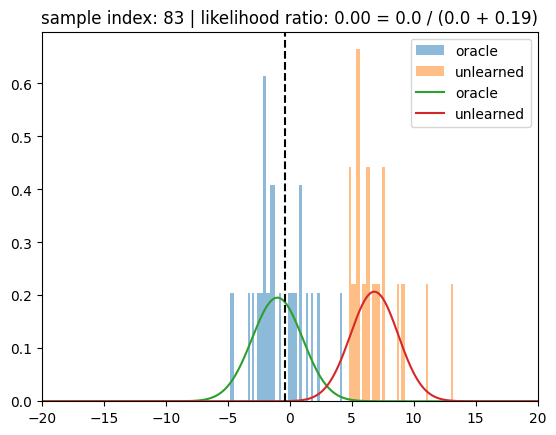

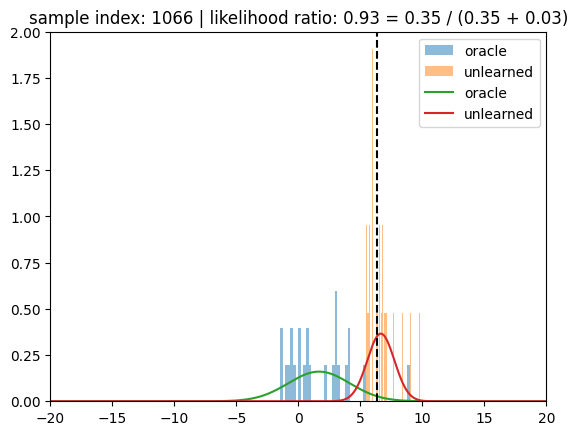

model - score: 0.8175
model 1
model - score: 0.835
model 2
model - score: 0.8275
model 3
model - score: 0.8
model 4


KeyboardInterrupt: 

In [15]:
# get 200 points from class 5 that are not from the forgettable_points
#forgettable_indices
def get_test_points_for_ulira(forget_indices, forgettable_indices, num_test_points=200, seed = 42):
    """
    get 200 points forgettable points from class 5 that are not in the forget_indices
    """
    np.random.seed(seed)
    # copy forgettable_indices
    class_5 = forgettable_indices.copy()
    class_5 = np.array(list(set(class_5) - set(forget_indices)))
    np.random.shuffle(class_5)
    return list(class_5)[:num_test_points]

def gaussian_pdf(x, mean, std):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean) / std) ** 2)


def single_ulira(
        all_unlearned_margins: ch.Tensor,  # T x n
        all_oracle_margins: ch.Tensor,  # T x n
        unlearned_model_margin: float,
        sample_ind,
        threshold=0.5,
        plot=False):
    """
    Compute the ULIRA (Unlearning Likelihood Ratio) results for each sample. for a single unlearned model.

    Note: 
        1: (x,y) is likely a member of training (unlearned model)
        0: (x,y) is likely a member of the oracle (oracle model)

    Args:
        all_unlearned_margins (ch.Tensor): Tensor of shape T x n containing the margins of all unlearned models.
        all_oracle_margins (ch.Tensor): Tensor of shape T x n containing the margins of all oracle models.
        hold_out_model (int): Index of the hold-out model.
        threshold (float, optional): Threshold value for the likelihood ratio. Defaults to 0.5.

    Returns:
        np.ndarray: Array of ULIRA results for each sample, where 1 indicates the likelihood ratio is above the threshold, and 0 otherwise.
    """
    #
    oracle_margins = all_oracle_margins[:, sample_ind].cpu().numpy()
    unlearned_margins = all_unlearned_margins[:, sample_ind].cpu().numpy()

    #
    #unlearned_model_margin = unlearned_margins[hold_out_model]
    #other_unlearned_models = np.delete(unlearned_margins, hold_out_model)

    # fit gaussians
    oracle_mean, oracle_std = np.mean(oracle_margins), np.std(oracle_margins)
    unlearned_mean, unlearned_std = np.mean(unlearned_margins), np.std(
        unlearned_margins)
    #print(f"aaa ({np.round(oracle_mean,2)}, {np.round(oracle_std,2)}) vs ({np.round(unlearned_mean,2)}, {np.round(unlearned_std,2)})")
    # compute LIRA
    unlearned_model_margin = float(unlearned_model_margin)

    oracle_prob = gaussian_pdf(unlearned_model_margin, oracle_mean, oracle_std)
    unlearned_prob = gaussian_pdf(unlearned_model_margin, unlearned_mean,
                                  unlearned_std)

    likelihood_ratio = unlearned_prob / (unlearned_prob + oracle_prob)

    # print(f"likelihood_ratio - {likelihood_ratio} : type - {type(likelihood_ratio)}")

    likelihood_ratio = float(likelihood_ratio)
    if plot:
        # plot gaussians
        plt.xlim(-20, 20)
        x = np.linspace(-20, 20, 1000)
        plt.hist(oracle_margins,
                 bins=50,
                 alpha=0.5,
                 label="oracle",
                 density=True)
        plt.hist(unlearned_margins,
                 bins=50,
                 alpha=0.5,
                 label="unlearned",
                 density=True)
        oracle_pdf = gaussian_pdf(x, oracle_mean, oracle_std)
        unlearned_pdf = gaussian_pdf(x, unlearned_mean, unlearned_std)
        plt.title(
            f"sample index: {sample_ind} | likelihood ratio: {round(likelihood_ratio,2):.2f} = {round(unlearned_prob,2)} / ({round(unlearned_prob,2)} + {round(oracle_prob,2)})"
        )
        plt.plot(x, oracle_pdf, label="oracle")
        plt.plot(x, unlearned_pdf, label="unlearned")
        plt.axvline(unlearned_model_margin, color="black", linestyle="--")
        plt.legend()
        plt.show()
    # save result
    return float(likelihood_ratio > threshold)


def get_training_models_with_and_without(masks, index):
    """
    return indices of models with and without the point
    """
    m = masks[:, index].T

    with_index, without_index = np.where(m == 1)[0], np.where(m == 0)[0]
    return with_index, without_index



def get_models_with_pt_forgotten(masks, forget_mask, sample_index):
    """
    find the indices where the point is in the plan and in the forget mask
    """

    models_with = []
    models_inds_with, _ = get_training_models_with_and_without(
    masks, sample_index)

    for model_ind in models_inds_with:
        if forget_mask[model_ind, sample_index] == 1:
            models_with.append(model_ind)
    return np.array(models_with)

def get_models_with_pt_retained(masks, forget_mask, sample_index):
    """
    find the indices where the point is in the plan and in the forget mask
    """

    models_with = []
    models_inds_with, _ = get_training_models_with_and_without(
    masks, sample_index)

    for model_ind in models_inds_with:
        if forget_mask[model_ind, sample_index] == 0:
            models_with.append(model_ind)
    return np.array(models_with)


def do_ulira_on_one_model(indices,
                          correct_ulira_label,
                          target_margins,
                          shadow_unlearning_margins,
                          shadow_oracle_margins,
                          forget_masks,
                          training_masks,
                          plot_index=-1, verbose=  False ):
    """

    """
    correct_ulira = 0
    ulira_labels = []
    for i, sample_index in enumerate(indices):

        # get models with x forgotten and models that never saw x
        models_with_x_forgotten = get_models_with_pt_forgotten(
            training_masks, forget_masks, sample_index)
        _, models_without_x = get_training_models_with_and_without(
            training_masks, sample_index)

        num_models_with_x_forgotten = len(models_with_x_forgotten)
        num_models_without_x = len(models_without_x)
        if verbose:
            print(f"num_models_with_x_forgotten - {num_models_with_x_forgotten}")
            print(f"num_models_without_x - {num_models_without_x}")

        max_models = 150

        min_models = min(num_models_with_x_forgotten, num_models_without_x)
        min_models = min(max_models, min_models)
        #
        #print(f"min models - {min_models    }")
        #min_models = -1
        models_with_x_forgotten = models_with_x_forgotten[:min_models]
        models_without_x = models_without_x[:min_models]

        # the margin of the target model on sample index
        target_margin = target_margins[sample_index]

        # we want to do a lira test between unlearned models that saw x
        # and unlearned models that did not see x

        ulira_label = single_ulira(
            shadow_unlearning_margins[models_with_x_forgotten],
            shadow_unlearning_margins[models_without_x],
            target_margin,
            sample_index,
            plot=(i == plot_index))
        if False:
            ulira_label = single_ulira(
                shadow_unlearning_margins[models_with_x_forgotten],
                shadow_oracle_margins[models_without_x],
                target_margin,
                sample_index,
                plot=(i == plot_index))
        ulira_labels.append(ulira_label)
        if ulira_label == correct_ulira_label:
            correct_ulira += 1
    return correct_ulira


"""
BEEP BOOP BAAP
ROY 
so, it looks like the plotting looks correct, but the ulira paper does not
i suspect that im passing in the wrong masks - look at waht you do for the plotting


at the same:
* it kind of looks like lieklihood ratios are exactly flipped

"""


def ulira_paper(all_unlearned_margins_ulira: ch.Tensor,
                all_oracle_margins_ulira: ch.Tensor,
                forget_masks,
                training_masks,
                plot_index=-1,
                verbose=False,
                max_models=None):
    """
    forgettable_points_ind, # which of the forgettable points we are looking at 

    """
    #sample_ind = forgettable_points[forgettable_points_ind]
    #oracle_count, N = training_masks.shape
    unlearning_count = all_unlearned_margins_ulira.shape[0]  # 1000
    shadow_count = unlearning_count // 2  # 500

    # target models are first 500 unlearned models
    target_unlearning_margins = all_unlearned_margins_ulira[:shadow_count]
    target_oracle_margins = all_oracle_margins_ulira[:shadow_count]
    target_forget_masks = forget_masks[:shadow_count]
    target_training_masks = training_masks[:shadow_count]
    ###

    shadow_unlearning_margins = all_unlearned_margins_ulira[
        shadow_count:unlearning_count]
    shadow_oracle_margins = all_oracle_margins_ulira[
        shadow_count:unlearning_count]
    shadow_forget_masks = forget_masks[shadow_count:unlearning_count]
    shadow_training_masks = training_masks[shadow_count:unlearning_count]

    #print(f"shadow_forget_masks.shape - {shadow_forget_masks.shape}")
    #print(f"target_forget_masks - {target_forget_masks.shape}")

    # get the set of indices that models consider forgetting
    forgettable_indices = list(sorted(get_forgettable_indices(forget_masks)))

    model_scores = []
    model_count = len(target_unlearning_margins)
    if max_models is not None:
        model_count = max_models

    for model_i in range(model_count):
        print(f"model {model_i}")
        target_margins = target_unlearning_margins[model_i]

        # indices that model_i forgot
        #forget_indices = target_forget_masks[model_i].nonzero()[0]
        target_forget_set_mask = target_forget_masks[model_i]
        target_training_set_mask = target_training_masks[model_i]

        forget_mask_ = np.array(target_forget_set_mask *
                                target_training_set_mask,
                                dtype=bool)
        forget_indices = forget_mask_.nonzero()[0]
        forget_pt_count = len(forget_indices)
        # indices that model_i never saw # BEEP BOOP BAAP < could be here.
        test_indices = get_test_points_for_ulira(
            forget_indices,
            forgettable_indices,
            num_test_points=forget_pt_count,
            seed=42)

        # take 200 points that the model never saw
        #target_training_set_indices = target_training_set_mask.nonzero()[0]
        #print(target_training_set_mask)
        #target_unseen_training_mask = 1- target_training_set_mask
        seen_training_indices = target_training_set_mask.nonzero()[0]
        #unseen_training_indices = target_unseen_training_mask.nonzero()[0]
        # test indiices is forgettable indices that have have never been seen by the model
        test_indices = list(
            set(forgettable_indices) - set(seen_training_indices))
        test_indices = sorted(list(test_indices))[:forget_pt_count]
        if verbose:
            print(f"we want a 0")

        if model_i == 0:
            plot_index = 4
        else:
            plot_index = -1

        # NOTE -  we don't want oracles. we want shadow models that never saw the point
        #
        test_ulira_correct = do_ulira_on_one_model(test_indices,
                                                   0,
                                                   target_margins,
                                                   shadow_unlearning_margins,
                                                   shadow_oracle_margins,
                                                   shadow_forget_masks,
                                                   shadow_training_masks,
                                                   plot_index=plot_index)
        if verbose:
            print(f"we want a 1")
        # forget indices
        forget_ulira_correct = do_ulira_on_one_model(forget_indices,
                                                     1,
                                                     target_margins,
                                                     shadow_unlearning_margins,
                                                     shadow_oracle_margins,
                                                     shadow_forget_masks,
                                                     shadow_training_masks,
                                                     plot_index=plot_index)

        model_score = (test_ulira_correct + forget_ulira_correct) / (
            len(test_indices) + len(forget_indices))
        model_scores.append(model_score)
        if verbose:
            print(f"test_ulira_correct- {test_ulira_correct} ||")
        print(
            f"model - score: {model_score}"
        )
    #raise
    return (model_scores)



# BEEP BOOP BAAP - this is where it gets run
# ROY - get to here. and check that there are all 1500 unlearnings! godspeed.
# check that you have the right forgetset too!

noop = True# False
if noop:
    #forget_masks = ulira.get_ulira_forget_mask(ds_name, class_5_range=1000, overwrite=False )
    #forget_masks_ = generate_ulira_forget_mask(dataset_name, class_5_range=5000, training_mask=training_masks)

    model_scores = ulira_paper(all_oracle_margins_ulira,
                               all_oracle_margins_ulira,
                               forget_masks,
                               training_masks,
                               max_models=10,
                               plot_index=0)

else:
    model_scores = ulira_paper(all_unlearned_margins_ulira,
                               all_oracle_margins_ulira,
                               forget_masks,
                               training_masks,
                               plot_index=0,
                               max_models=100,
                               verbose=False)
# 48883

In [23]:
np.mean(model_scores)
#np.mean((0.8125, 0.8475,0.8425, 0.805, 0.785, 0.8325, 0.82, 0.8225, 0.7825, 0.83, 0.79))

0.5041249999999999

In [ ]:
splits = ["train", "val"]

ulira_model_ckpt_paths, _, _ = ulira.get_ulira_model_paths(ds_name,
                                                           splits=splits)
ulira_model_ckpt_paths[-1]

MASK_PATH = Path(
    f"/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/ULIRA_clean/training_masks.npy"
)
m = np.load(MASK_PATH)
m.shape

(2000, 50000)

In [ ]:
sum(m[0])


25000

this is plotting - model 0 on the forget set vs the test set
model 0


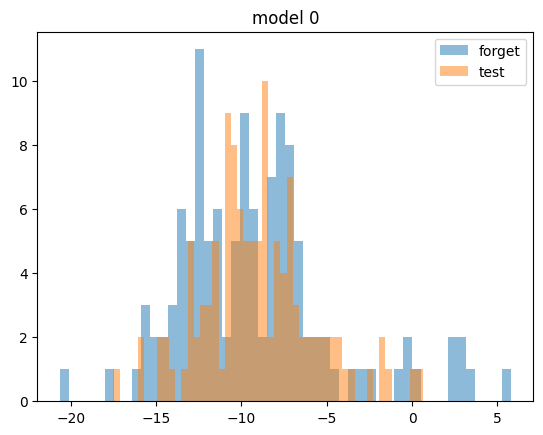

model 1


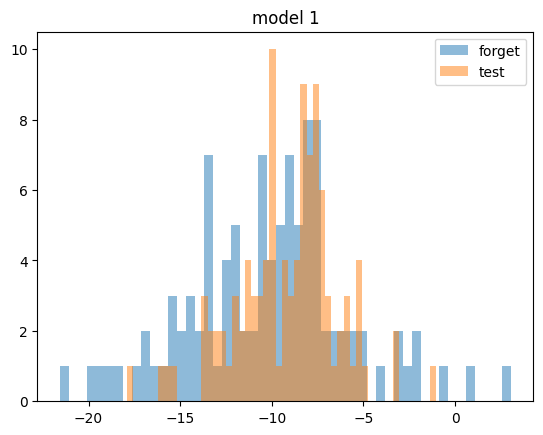

model 2


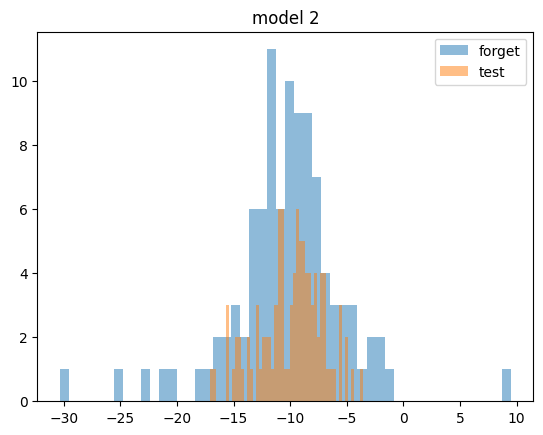

model 3


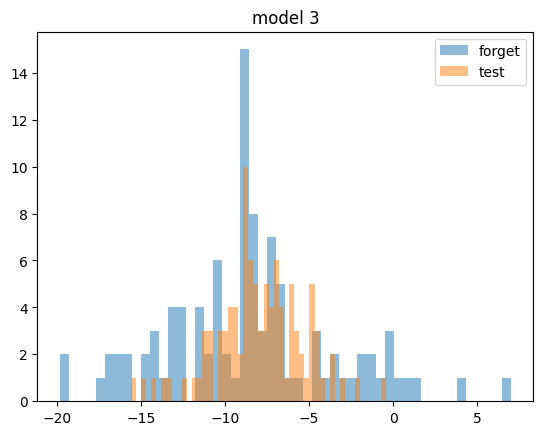

In [ ]:
def sanity_check_1(all_unlearned_margins_ulira: ch.Tensor,
                   all_oracle_margins_ulira: ch.Tensor,
                   forget_masks,
                   training_masks,
                   plot_index=-1):
    """
    forgettable_points_ind, # which of the forgettable points we are looking at 

    """
    #sample_ind = forgettable_points[forgettable_points_ind]
    #oracle_count, N = training_masks.shape
    unlearning_count = all_unlearned_margins_ulira.shape[0]  # 1000
    shadow_count = unlearning_count // 2  # 500

    # target models are first 500 unlearned models
    target_unlearning_margins = all_unlearned_margins_ulira[:shadow_count]
    target_oracle_margins = all_oracle_margins_ulira[:shadow_count]
    target_forget_masks = forget_masks[:shadow_count]
    target_training_masks = training_masks[:shadow_count]
    ###

    shadow_unlearning_margins = all_unlearned_margins_ulira[
        shadow_count:unlearning_count]
    shadow_oracle_margins = all_oracle_margins_ulira[
        shadow_count:unlearning_count]
    shadow_forget_masks = forget_masks[shadow_count:unlearning_count]
    shadow_training_masks = training_masks[shadow_count:unlearning_count]

    #print(f"shadow_forget_masks.shape - {shadow_forget_masks.shape}")
    #print(f"target_forget_masks - {target_forget_masks.shape}")

    # get the set of indices that models consider forgetting
    forgettable_indices = get_forgettable_indices(forget_masks)
    model_scores = []
    model_count = len(target_unlearning_margins)
    model_count = 4
    for model_i in range(model_count):
        print(f"model {model_i}")
        # margins of model i
        target_margins = target_unlearning_margins[model_i]

        # indices that model_i forgot
        forget_indices = target_forget_masks[model_i].nonzero()[0]
        forget_pt_count = len(forget_indices)

        test_indices = get_test_points_for_ulira(
            forget_indices,
            forgettable_indices,
            num_test_points=forget_pt_count,
            seed=42)


        target_forget_set_mask = target_forget_masks[model_i]
        target_training_set_mask = target_training_masks[model_i]

        forget_mask_ = np.array(target_forget_set_mask *
                                target_training_set_mask,
                                dtype=bool)
        forget_indices = forget_mask_.nonzero()[0]
        forget_pt_count = len(forget_indices)
        # indices that model_i never saw # BEEP BOOP BAAP < could be here.
        test_indices = get_test_points_for_ulira(
            forget_indices,
            forgettable_indices,
            num_test_points=forget_pt_count,
            seed=42)

        seen_training_indices = target_training_set_mask.nonzero()[0]
        test_indices = list(
            set(forgettable_indices) - set(seen_training_indices))
        test_indices = sorted(list(test_indices))[:forget_pt_count]



        # plot histogram of margins in test and forget
        plt.title(f"model {model_i}")
        plt.hist(target_margins[forget_indices],
                 bins=50,
                 alpha=0.5,
                 label="forget")
        plt.hist(target_margins[test_indices],
                 bins=50,
                 alpha=0.5,
                 label="test")
        plt.legend()
        plt.show()
    return (model_scores)

print(f"this is plotting - model 0 on the forget set vs the test set")
model_scores = sanity_check_1(all_unlearned_margins_ulira,
                            all_oracle_margins_ulira,
                            forget_masks,
                            training_masks,
                            plot_index=0)

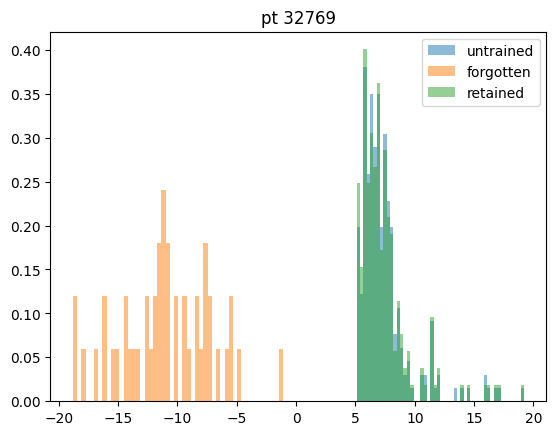

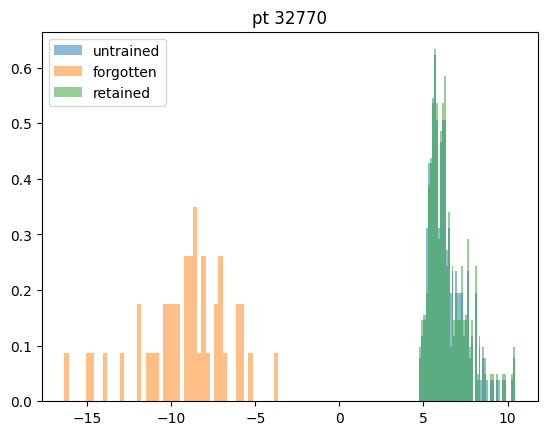

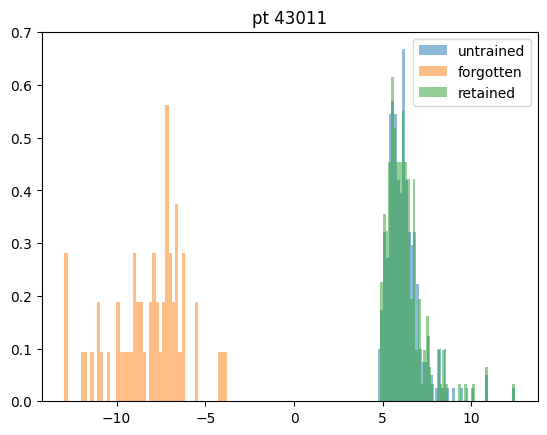

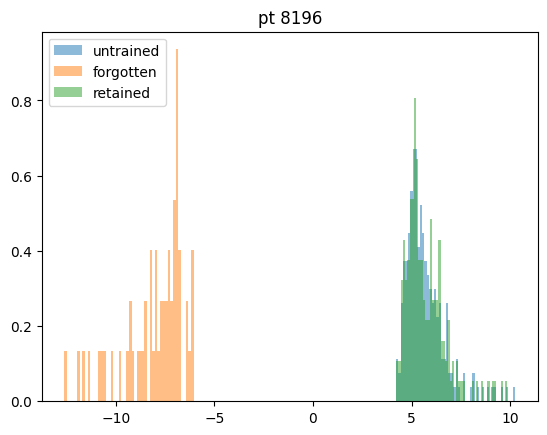

In [ ]:
def sanity_check_2(all_unlearned_margins_ulira: ch.Tensor,
                   all_oracle_margins_ulira: ch.Tensor,
                   forget_masks,
                   training_masks,
                   plot_index=-1):
    """
    forgettable_points_ind, # which of the forgettable points we are looking at 

    """
    #sample_ind = forgettable_points[forgettable_points_ind]
    #oracle_count, N = training_masks.shape
    unlearning_count = all_unlearned_margins_ulira.shape[0]  # 1000
    shadow_count = unlearning_count // 2  # 500

    # target models are first 500 unlearned models
    target_unlearning_margins = all_unlearned_margins_ulira[:shadow_count]
    target_oracle_margins = all_oracle_margins_ulira[:shadow_count]
    target_forget_masks = forget_masks[:shadow_count]
    target_training_masks = training_masks[:shadow_count]
    ###

    shadow_unlearning_margins = all_unlearned_margins_ulira[
        shadow_count:unlearning_count]
    shadow_oracle_margins = all_oracle_margins_ulira[
        shadow_count:unlearning_count]
    shadow_forget_masks = forget_masks[shadow_count:unlearning_count]
    shadow_training_masks = training_masks[shadow_count:unlearning_count]

    #print(f"shadow_forget_masks.shape - {shadow_forget_masks.shape}")
    #print(f"target_forget_masks - {target_forget_masks.shape}")

    # get the set of indices that models consider forgetting
    forgettable_indices = get_forgettable_indices(forget_masks)
    model_scores = []
    model_count = len(target_unlearning_margins)
    model_count = 4
    points_of_interest = forgettable_indices[:model_count]
    for point_of_interest in points_of_interest:
        # models that never saw points_of_interest
        models_without_x, _ = get_training_models_with_and_without(
            target_training_masks, point_of_interest)
        # models that forgot points_of_interest
        models_with_x_forgotten = get_models_with_pt_forgotten(
            target_training_masks, target_forget_masks, point_of_interest)
        # models that retained x
        models_with_x_retained = get_models_with_pt_retained(
            target_training_masks, target_forget_masks, point_of_interest)

        unlearned_margins_of_interest = target_unlearning_margins[:,
                                                                  point_of_interest]
        oracle_margins_of_interest = target_oracle_margins[:,
                                                           point_of_interest]

        untrained_margins = oracle_margins_of_interest[models_without_x]
        forgotten_margins = unlearned_margins_of_interest[models_with_x_forgotten]
        retained_margins = oracle_margins_of_interest[models_with_x_retained]

        # plot histogram of margins in test and forget
        plt.title(f"pt {point_of_interest}")
        density = True
        plt.hist(untrained_margins,
                 bins=50,
                 alpha=0.5,
                 label="untrained",
                 density=density)
        plt.hist(forgotten_margins,
                 bins=50,
                 alpha=0.5,
                 label="forgotten",
                 density=density)
        plt.hist(retained_margins,
                 bins=50,
                 alpha=0.5,
                 label="retained",
                 density=density)
        plt.legend()
        plt.show()
    return


model_scores = sanity_check_2(all_unlearned_margins_ulira,
                            all_oracle_margins_ulira,
                            forget_masks,
                            training_masks,
                            plot_index=0)

did it get it correct- False? | true label - True | ulira label - 0


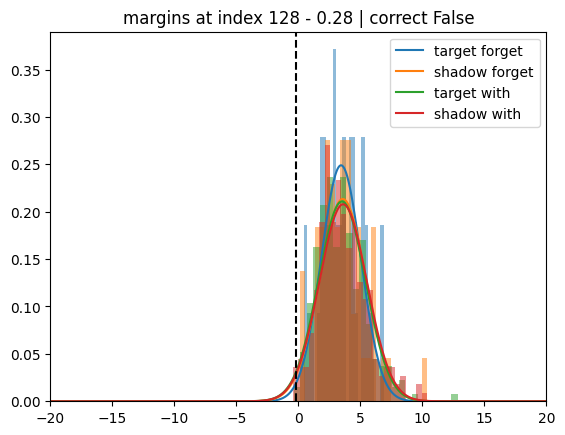

did it get it correct- True? | true label - True | ulira label - 1


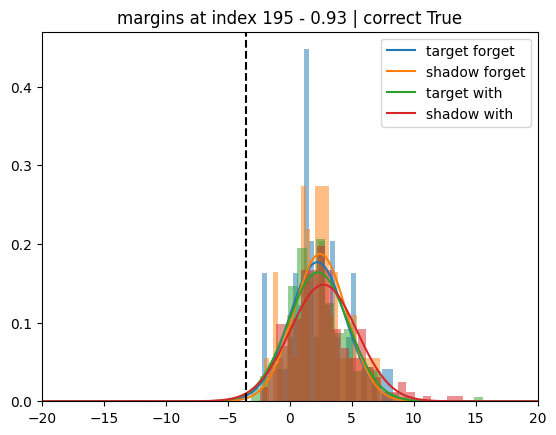

did it get it correct- False? | true label - True | ulira label - 0


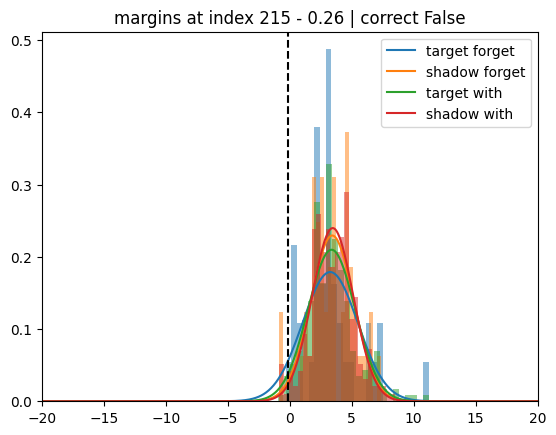

did it get it correct- False? | true label - True | ulira label - 0


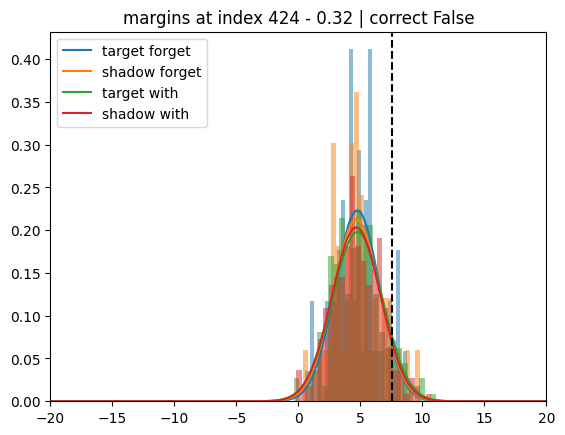

did it get it correct- False? | true label - True | ulira label - 0


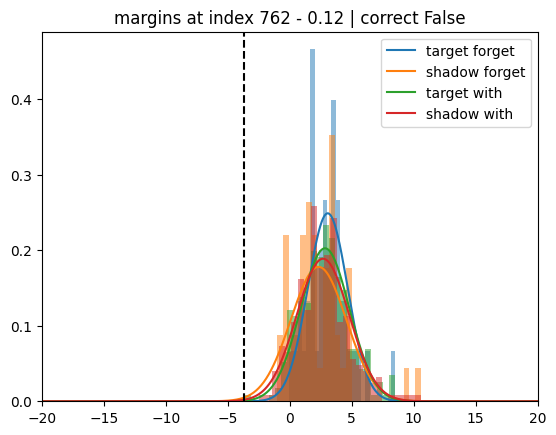

did it get it correct- False? | true label - True | ulira label - 0


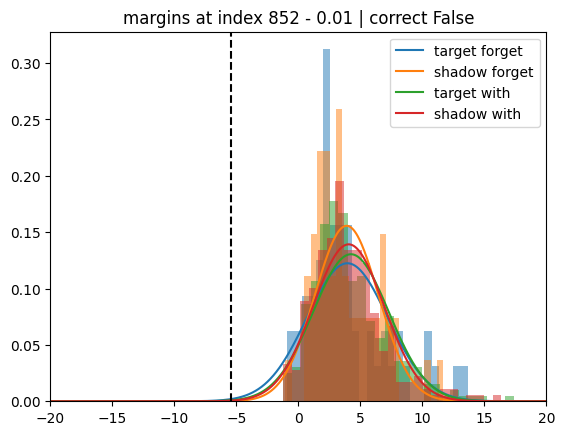

did it get it correct- True? | true label - True | ulira label - 1


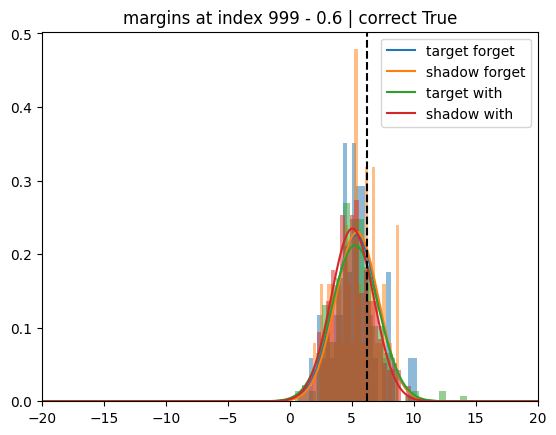

did it get it correct- True? | true label - True | ulira label - 1


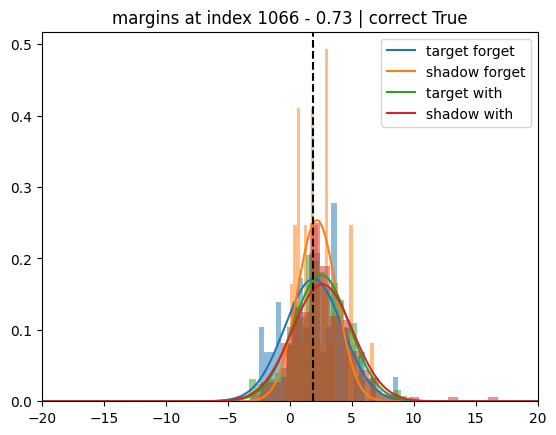

did it get it correct- True? | true label - True | ulira label - 1


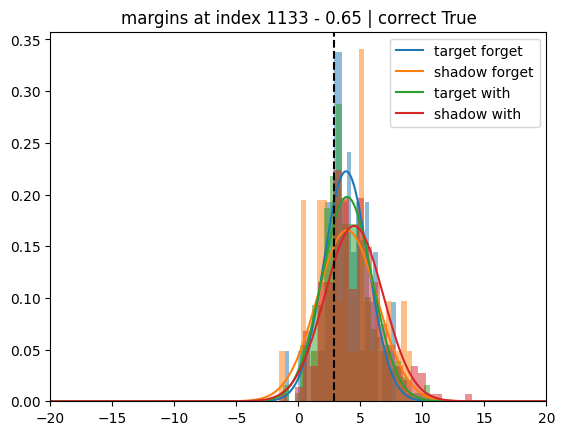

did it get it correct- False? | true label - True | ulira label - 0


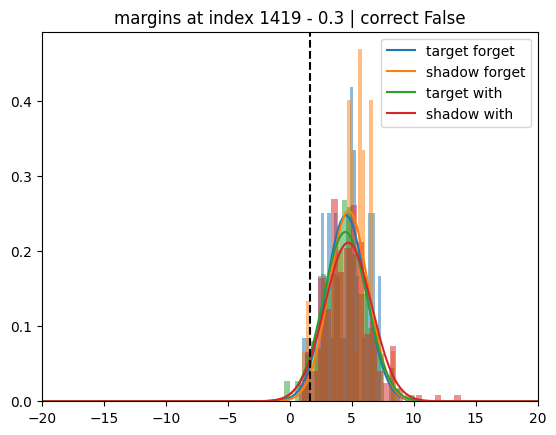

did it get it correct- False? | true label - False | ulira label - 1


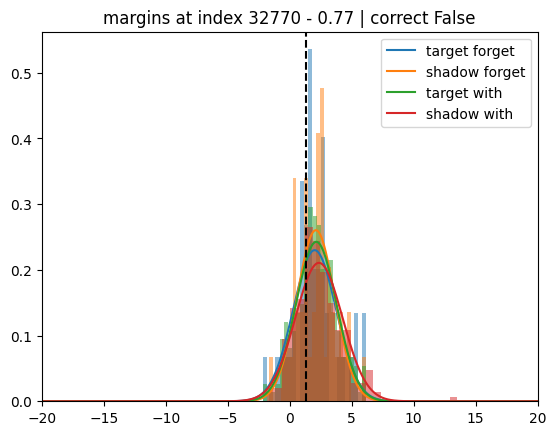

did it get it correct- False? | true label - False | ulira label - 1


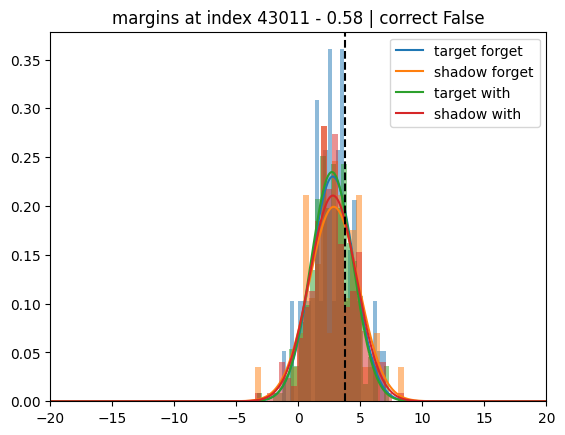

did it get it correct- True? | true label - False | ulira label - 0


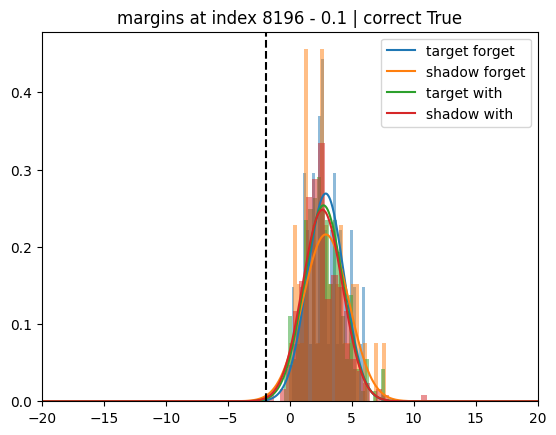

did it get it correct- False? | true label - False | ulira label - 1


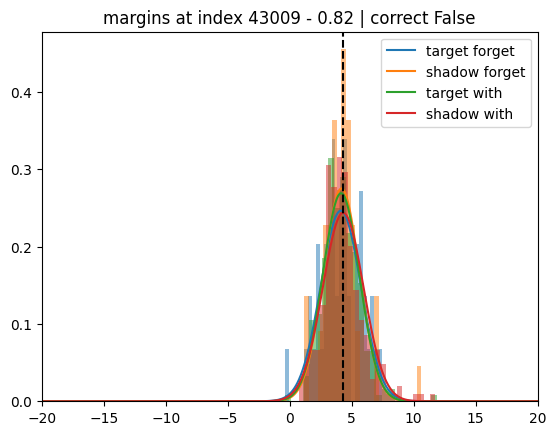

did it get it correct- False? | true label - False | ulira label - 1


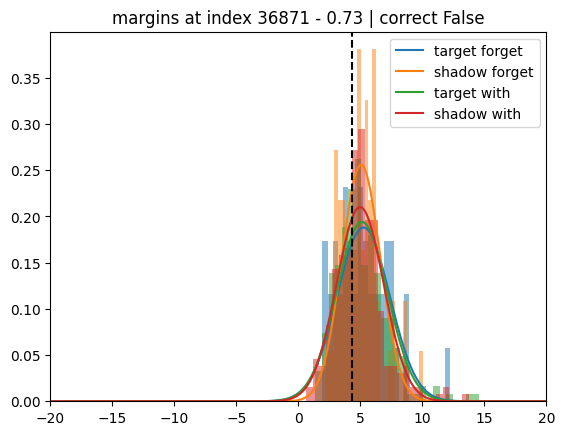

did it get it correct- False? | true label - False | ulira label - 1


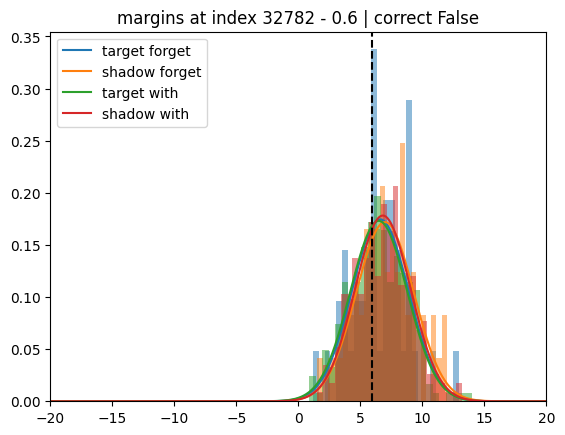

did it get it correct- False? | true label - False | ulira label - 1


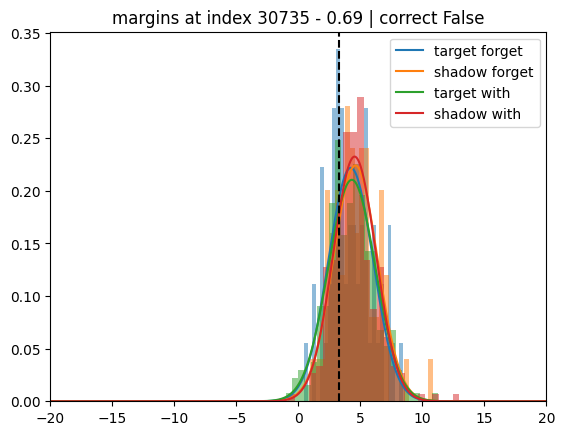

did it get it correct- False? | true label - False | ulira label - 1


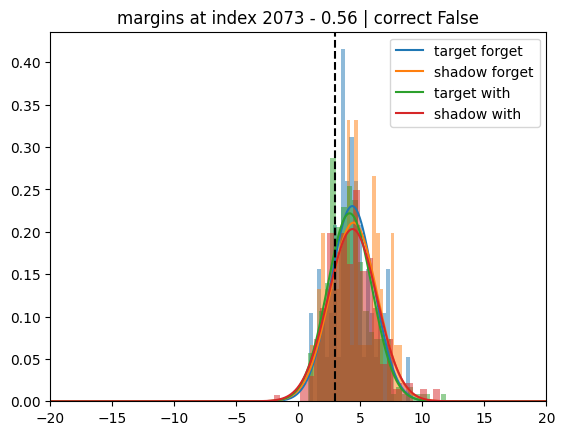

did it get it correct- False? | true label - False | ulira label - 1


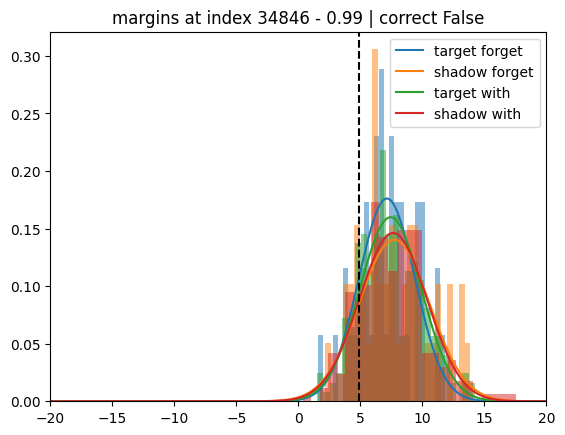

did it get it correct- False? | true label - False | ulira label - 1


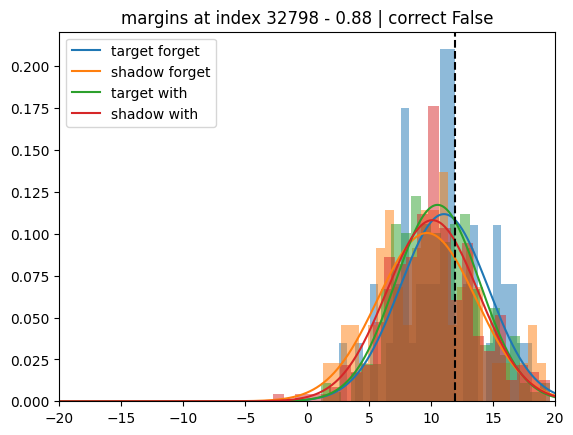

total_correct - 5 / 20


In [ ]:
def computation_round_2(
    all_unlearned_margins_ulira: ch.Tensor,
    all_oracle_margins_ulira: ch.Tensor,
    forget_masks,
    training_masks,
):
    """
    forgettable_points_ind, # which of the forgettable points we are looking at 

    """
    #sample_ind = forgettable_points[forgettable_points_ind]
    #oracle_count, N = training_masks.shape
    unlearning_count = all_unlearned_margins_ulira.shape[0]  # 1000
    shadow_count = unlearning_count // 2  # 500

    # target models are first 500 unlearned models
    target_unlearning_margins = all_unlearned_margins_ulira[:shadow_count]
    target_oracle_margins = all_oracle_margins_ulira[:shadow_count]
    target_forget_masks = forget_masks[:shadow_count]
    target_training_masks = training_masks[:shadow_count]
    ###

    shadow_unlearning_margins = all_unlearned_margins_ulira[
        shadow_count:unlearning_count]
    shadow_oracle_margins = all_oracle_margins_ulira[
        shadow_count:unlearning_count]
    shadow_forget_masks = forget_masks[shadow_count:unlearning_count]
    shadow_training_masks = training_masks[shadow_count:unlearning_count]

    #print(f"shadow_forget_masks.shape - {shadow_forget_masks.shape}")
    #print(f"target_forget_masks - {target_forget_masks.shape}")

    # get the set of indices that models consider forgetting
    forgettable_indices = get_forgettable_indices(forget_masks)

    target_model_ind = 1
    target_model_margins = target_unlearning_margins[target_model_ind]
    # is plot_index in forget point for index 0
    forget_indices = target_forget_masks[target_model_ind].nonzero()[0]
    # forgettable_indices - forget_indices
    retain_indices = list(set(forgettable_indices) - set(forget_indices))

    # indices to plot
    num_indices = 10
    plot_indices = list(forget_indices[:num_indices]) + list(
        retain_indices[:num_indices])
    #print(f"plot_indices- {plot_indices}")
    #plot_index = 3
    #plot_indices = forgettable_indices[:10]

    #plot_indices = [851, 195]
    #plot_indices = [48883]
    total_correct = 0
    for plot_index in plot_indices:  #[0,-1, forgettable_indices[0], forgettable_indices[1], forgettable_indices[100]]:
        # get target_models
        # indices that model_i forgot
        # models with index in forget_set, and models without
        target_models_with_index, target_models_without_index = get_training_models_with_and_without(
            target_training_masks, plot_index)

        target_margins_with = target_unlearning_margins[
            target_models_with_index]
        target_margins_without = target_unlearning_margins[
            target_models_without_index]

        shadow_models_with_index, shadow_models_without_index = get_training_models_with_and_without(
            shadow_training_masks, plot_index)
        shadow_margins_with = shadow_unlearning_margins[
            shadow_models_with_index]
        shadow_margins_without = shadow_unlearning_margins[
            shadow_models_without_index]

        # get models that forgot the point
        target_models_forgot_indices = get_models_with_pt_forgotten(
            target_training_masks, target_forget_masks, plot_index)

        target_margins_forget = target_unlearning_margins[
            target_models_forgot_indices]
        shadow_models_forgot_indices = get_models_with_pt_forgotten(
            shadow_training_masks, shadow_forget_masks, plot_index)
        shadow_margins_forget = shadow_unlearning_margins[
            shadow_models_forgot_indices]

        ###

        def get_gaussian_at_point(pts, ind):
            pts_ = pts[:, ind].cpu().numpy()
            mean, std = np.mean(pts_), np.std(pts_)
            x = target_model_margins[ind]
            return gaussian_pdf(x, mean, std)

        forget_likelihood = get_gaussian_at_point(shadow_margins_forget,
                                                  plot_index)
        oracle_likelihood = get_gaussian_at_point(shadow_oracle_margins,
                                                  plot_index)
        likelihood_ratio = forget_likelihood / (forget_likelihood +
                                                oracle_likelihood)
        #cast likelihood_ratio to float
        likelihood_ratio = float(likelihood_ratio)
        #print(f"likelihood_ratio {type(likelihood_ratio)}")
        ulira_label = int(likelihood_ratio > 0.5)

        included_in_forget = plot_index in forget_indices

        correct = ulira_label == included_in_forget
        print(
            f"did it get it correct- {correct}? | true label - {included_in_forget} | ulira label - {ulira_label}"
        )
        total_correct += int(correct)
        if True:
            #####
            density = True
            plt.title(
                f"margins at index {plot_index} - {round(likelihood_ratio,2)} | correct {correct}"
            )

            def plot_hist(pts, ind, label):
                pts_ = pts[:, ind].cpu().numpy()
                mean, std = np.mean(pts_), np.std(pts_)
                # plt guassian
                x = np.linspace(-20, 20, 1000)
                plt.plot(x, gaussian_pdf(x, mean, std), label=label)
                # plts hist

                # get prev color
                c = plt.gca().lines[-1].get_color()

                plt.hist(
                    pts_,
                    bins=25,
                    alpha=0.5,
                    #label=label,
                    color=c,
                    density=density)

            # forget points
            plot_hist(target_margins_forget, plot_index, "target forget")
            plot_hist(shadow_margins_forget, plot_index, "shadow forget")
            bin_count = 25
            # test points
            plot_hist(target_margins_with, plot_index, "target with")
            plot_hist(shadow_margins_with, plot_index, "shadow with")
            x = target_model_margins[plot_index]
            plt.axvline(x, color="black", linestyle="--")
            plt.xlim(-20, 20)
            plt.legend()
            plt.show()
    print(f"total_correct - {total_correct} / {len(plot_indices)}")
computation_round_2(
    all_unlearned_margins_ulira,
    all_oracle_margins_ulira,
    forget_masks,
    training_masks,
)

it is included! - True


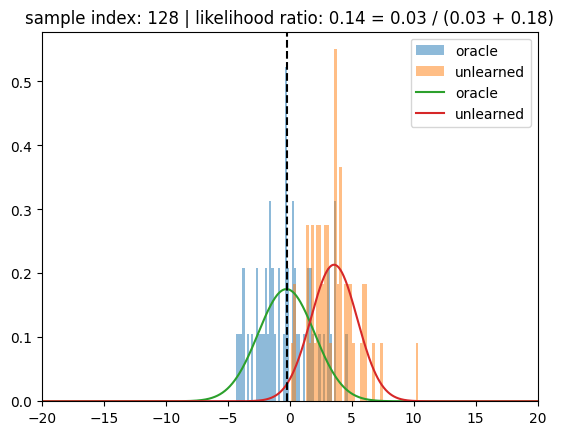

	[0.0]
did it get it correct- False?


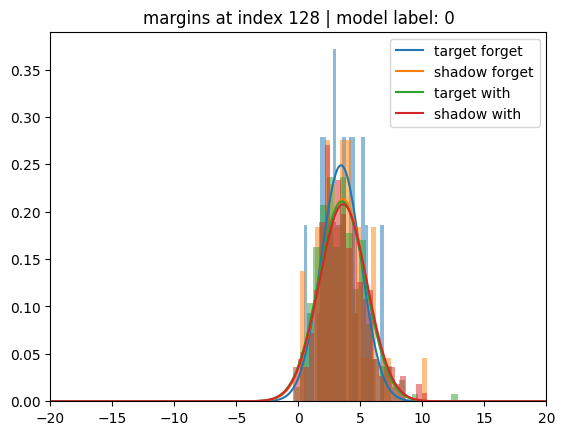

it is included! - True


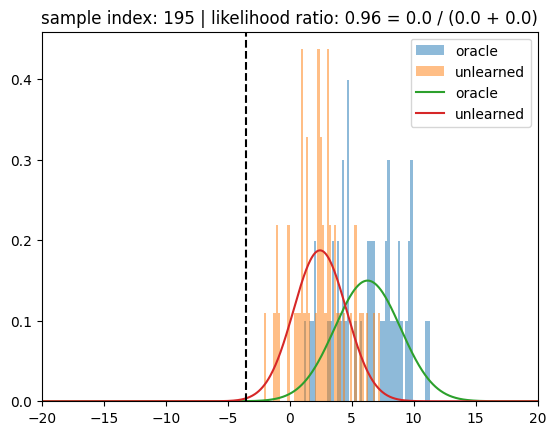

	[1.0]
did it get it correct- True?


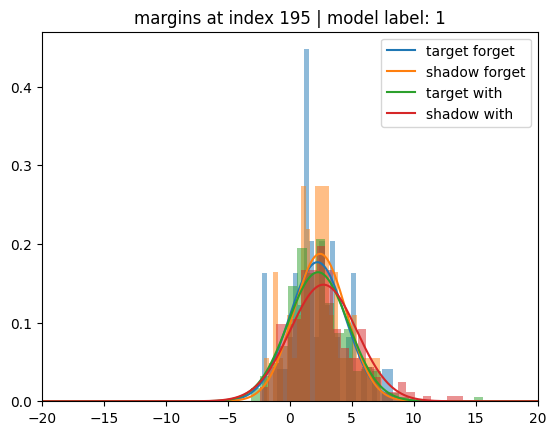

it is included! - True


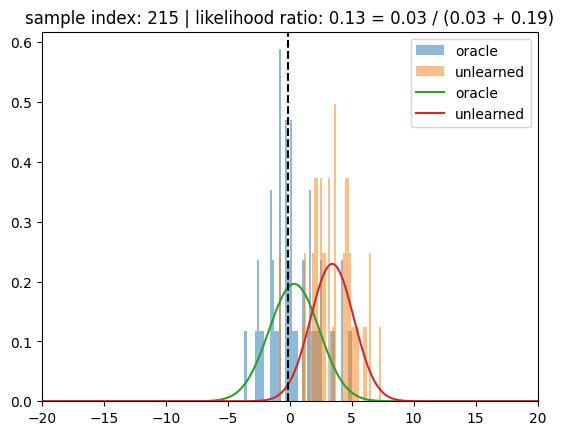

	[0.0]
did it get it correct- False?


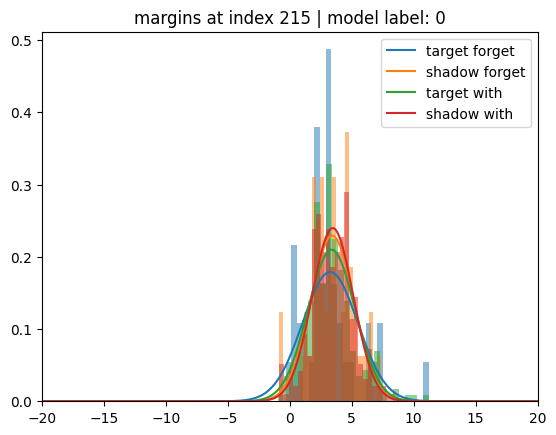

it is included! - True


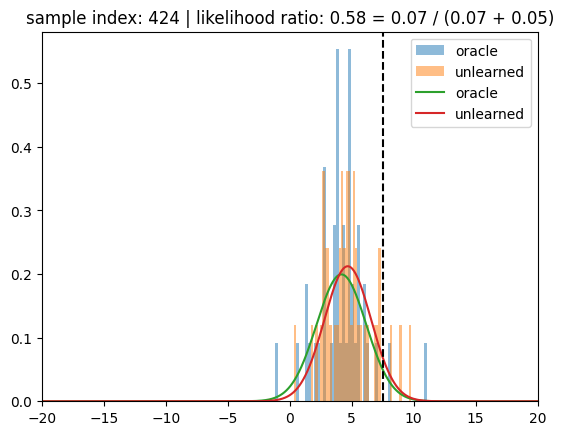

	[1.0]
did it get it correct- True?


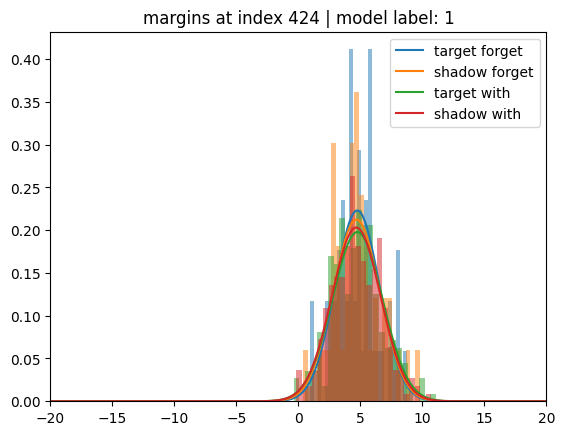

it is included! - False


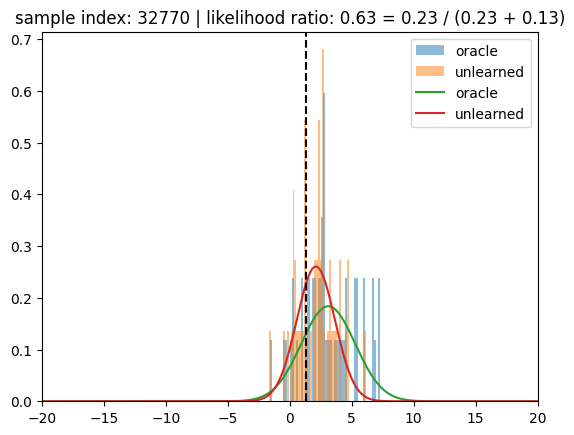

	[1.0]
did it get it correct- True?


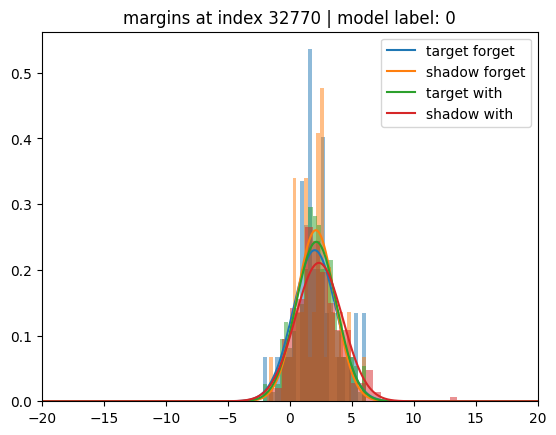

it is included! - False


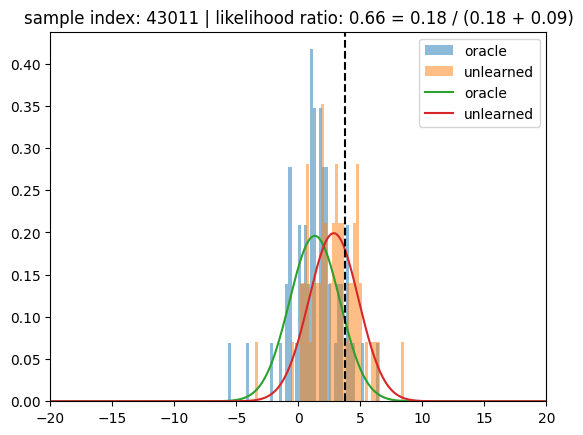

	[1.0]
did it get it correct- True?


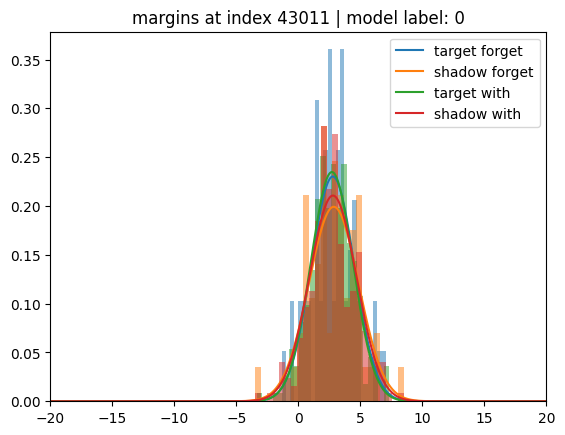

it is included! - False


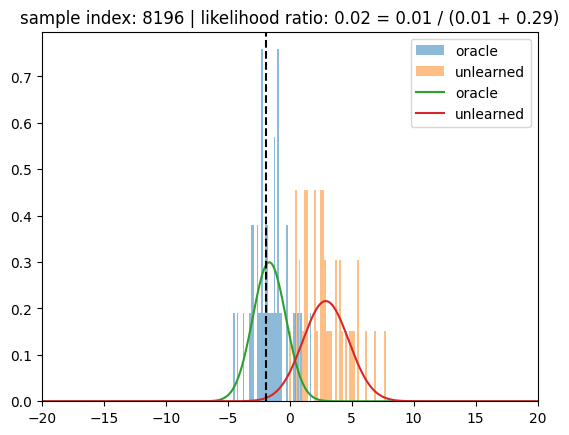

	[0.0]
did it get it correct- False?


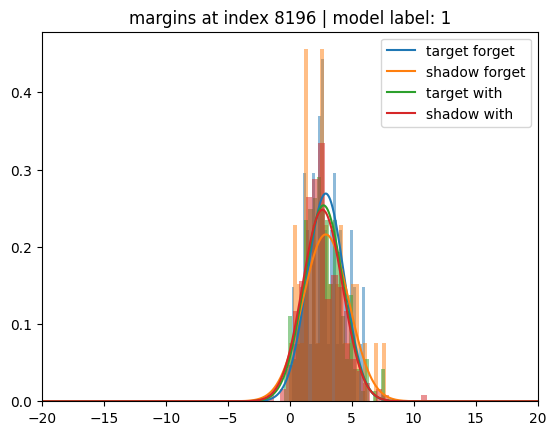

it is included! - False


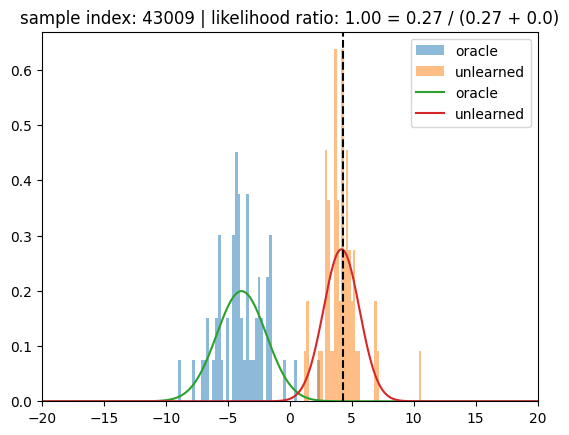

	[1.0]
did it get it correct- True?


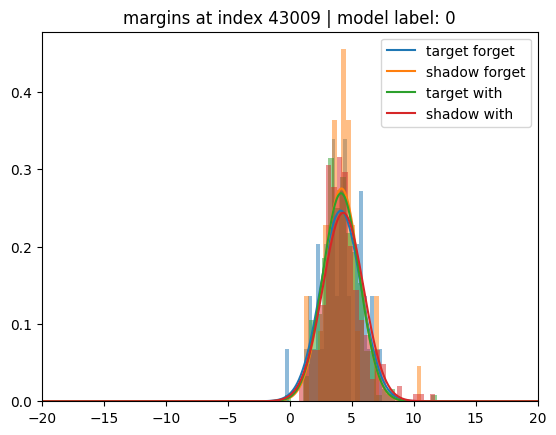

total_correct - 5 / 8


In [ ]:
def plotting_investigation(
    all_unlearned_margins_ulira: ch.Tensor,
    all_oracle_margins_ulira: ch.Tensor,
    forget_masks,
    training_masks,
):
    """
    forgettable_points_ind, # which of the forgettable points we are looking at 

    """
    #sample_ind = forgettable_points[forgettable_points_ind]
    #oracle_count, N = training_masks.shape
    unlearning_count = all_unlearned_margins_ulira.shape[0]  # 1000
    shadow_count = unlearning_count // 2  # 500

    # target models are first 500 unlearned models
    target_unlearning_margins = all_unlearned_margins_ulira[:shadow_count]
    target_oracle_margins = all_oracle_margins_ulira[:shadow_count]
    target_forget_masks = forget_masks[:shadow_count]
    target_training_masks = training_masks[:shadow_count]
    ###

    shadow_unlearning_margins = all_unlearned_margins_ulira[
        shadow_count:unlearning_count]
    shadow_oracle_margins = all_oracle_margins_ulira[
        shadow_count:unlearning_count]
    shadow_forget_masks = forget_masks[shadow_count:unlearning_count]
    shadow_training_masks = training_masks[shadow_count:unlearning_count]

    #print(f"shadow_forget_masks.shape - {shadow_forget_masks.shape}")
    #print(f"target_forget_masks - {target_forget_masks.shape}")

    # get the set of indices that models consider forgetting
    forgettable_indices = get_forgettable_indices(forget_masks)

    target_model_ind = 1
    target_model_margins = target_unlearning_margins[target_model_ind]
    # is plot_index in forget point for index 0
    forget_indices = target_forget_masks[target_model_ind].nonzero()[0]
    # forgettable_indices - forget_indices
    retain_indices = list(set(forgettable_indices) - set(forget_indices))

    # indices to plot
    plot_indices = list(forget_indices[:4]) + list(retain_indices[:4])
    #print(f"plot_indices- {plot_indices}")
    #plot_index = 3
    #plot_indices = forgettable_indices[:10]

    #plot_indices = [851, 195]
    #plot_indices = [48883]
    total_correct = 0
    for plot_index in plot_indices:  #[0,-1, forgettable_indices[0], forgettable_indices[1], forgettable_indices[100]]:
        # get target_models
        # indices that model_i forgot
        # models with index in forget_set, and models without
        target_models_with_index, target_models_without_index = get_training_models_with_and_without(
            target_training_masks, plot_index)

        target_margins_with = target_unlearning_margins[
            target_models_with_index]
        target_margins_without = target_unlearning_margins[
            target_models_without_index]

        shadow_models_with_index, shadow_models_without_index = get_training_models_with_and_without(
            shadow_training_masks, plot_index)
        shadow_margins_with = shadow_unlearning_margins[
            shadow_models_with_index]
        shadow_margins_without = shadow_unlearning_margins[
            shadow_models_without_index]

        # get models that forgot the point
        target_models_forgot_indices = get_models_with_pt_forgotten(
            target_training_masks, target_forget_masks, plot_index)

        target_margins_forget = target_unlearning_margins[
            target_models_forgot_indices]
        shadow_models_forgot_indices = get_models_with_pt_forgotten(
            shadow_training_masks, shadow_forget_masks, plot_index)
        shadow_margins_forget = shadow_unlearning_margins[
            shadow_models_forgot_indices]
        ###

        ####
        included_in_forget = plot_index in forget_indices
        # shadow_models_with_index
        # shadow_models_forgot_indices
        # could be that model_i is inccorectly index
        print(f"it is included! - {included_in_forget}")
        test_ulira_correct = do_ulira_on_one_model([plot_index],
                                                   included_in_forget,
                                                   target_model_margins,
                                                   shadow_unlearning_margins,
                                                   shadow_oracle_margins,
                                                   shadow_forget_masks,
                                                   shadow_training_masks,
                                                   plot_index=0)
        density = True
        correct = test_ulira_correct == included_in_forget
        print(f"did it get it correct- {correct}?")
        total_correct += int(correct)
        #####
        plt.title(
            f"margins at index {plot_index} | model label: {test_ulira_correct}"
        )

        def plot_hist(pts, ind, label):
            pts_ = pts[:, ind].cpu().numpy()
            mean, std = np.mean(pts_), np.std(pts_)
            # plt guassian
            x = np.linspace(-20, 20, 1000)
            plt.plot(x, gaussian_pdf(x, mean, std), label=label)
            # plts hist
            # get prev color
            c = plt.gca().lines[-1].get_color()

            plt.hist(
                pts_,
                bins=25,
                alpha=0.5,
                #label=label,
                color=c,
                density=density)

        # forget points
        plot_hist(target_margins_forget, plot_index, "target forget")
        plot_hist(shadow_margins_forget, plot_index, "shadow forget")
        if False:
            plt.hist(target_margins_forget[:, plot_index].cpu().numpy(),
                     bins=25,
                     alpha=0.5,
                     label="target forget",
                     density=density)
            plt.hist(shadow_margins_forget[:, plot_index].cpu().numpy(),
                     bins=25,
                     alpha=0.5,
                     label="shadow forget",
                     density=density)
        ####
        bin_count = 25
        # test points
        plot_hist(target_margins_with, plot_index, "target with")
        plot_hist(shadow_margins_with, plot_index, "shadow with")
        if False:
            plt.hist(target_margins_without[:, plot_index].cpu().numpy(),
                     bins=bin_count,
                     alpha=0.5,
                     label="target without",
                     density=density)
            plt.hist(shadow_margins_without[:, plot_index].cpu().numpy(),
                     bins=bin_count,
                     alpha=0.5,
                     label="shadow without",
                     density=density)
        plt.xlim(-20, 20)
        plt.legend()
        plt.show()
    print(f"total_correct - {total_correct} / {len(plot_indices)}")
plotting_investigation(
    all_unlearned_margins_ulira,
    all_oracle_margins_ulira,
    forget_masks,
    training_masks,
)


In [ ]:
# my confusion is 

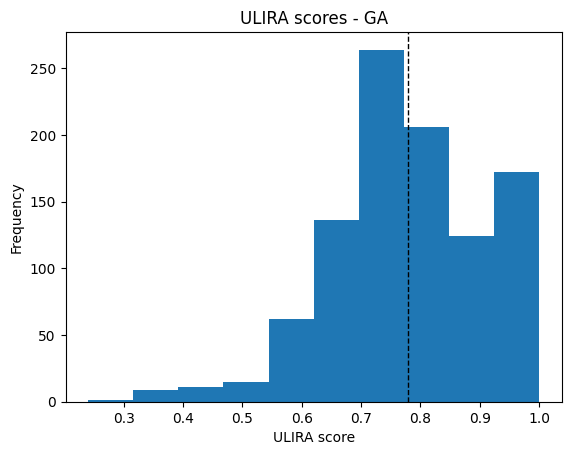

In [ ]:
mean = np.mean(forget_ulira_scores)
std = np.std(forget_ulira_scores)
method_name = "GA"
plt.hist(forget_ulira_scores)
plt.title(f"ULIRA scores - {method_name}")
plt.xlabel("ULIRA score")
plt.ylabel("Frequency")
# vert line at mean
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
plt.show()

In [ ]:
forget_masks[:4].shape

(4, 50000)

In [ ]:
training_masks.shape
forget_masks.shape

(2000, 50000)

In [ ]:
print(f"fall_unlearned_margins_ulira. - {all_unlearned_margins_ulira.shape }") # 1000 x N 
print(f"all_oracle_margins_ulira. - {all_oracle_margins_ulira.shape }") # 2000 x N

fall_unlearned_margins_ulira. - torch.Size([1000, 60000])
all_oracle_margins_ulira. - torch.Size([2000, 60000])


In [31]:
import re
import numpy as np
import torch as ch
from tqdm import tqdm
from pathlib import Path
from typing import List, Optional

from unlearning.unlearning_algos.utils import get_margin
from unlearning.auditors.direct import (
    direct_audit_precomputed,
    get_u_margins,
    u_margin_job,
    plot_margins_direct,
)
from scipy.stats import norm
import torch
from unlearning.auditors.utils import (
    loader_factory,
 )


import os
import shutil
import yaml
import numpy as np
import torch as ch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import logging
import pprint
from contextlib import redirect_stdout, redirect_stderr

from unlearning.auditors.utils import (
    model_factory,
    loader_factory,
    load_forget_set_indices,
    get_full_model_paths,

    get_oracle_paths,
    make_results_dir,
)
from unlearning.auditors.accuracies import eval_accuracy
from unlearning.auditors.logit_plots import compute_logits, plot_logits
from unlearning.auditors.basic import plot_margins

from unlearning.auditors.direct import (
    config_submitit,
    direct_audit_precomputed,
    get_u_margins,
    u_margin_job,
    plot_margins_direct,
)
from unlearning.auditors import ulira
from unlearning.unlearning_algos.base_nn import NAME_TO_ALGO


from contextlib import redirect_stdout, redirect_stderr


# 1. fix ulira accuracy measure! get test scores too !
# 2.  
# 

# load model from chkpt and evaluate accuracy 


def _model_factory(dataset, wrapped=True):
    """
    for now, let's tie the model to the dataset, so we have fewer moving pieces
    """
    if dataset.lower() == "cifar10":
        from unlearning.models.resnet9 import ResNet9

        return ResNet9(num_classes=10, wrapped=wrapped)

    elif dataset.lower() == "cifar100":
        from unlearning.models.resnet9 import ResNet9

        return ResNet9(num_classes=100)
    else:
        raise NotImplementedError

ds_name = "CIFAR10"
# for now, let's tie the model to the dataset, so we have fewer moving pieces
model = _model_factory(ds_name)  # on cuda, in eval mode
model

with redirect_stdout(open("/dev/null", "w")):
    # no shuffling, no augmentation
    train_loader = loader_factory(ds_name, indexed=True)
    val_loader = loader_factory(ds_name, split="val", indexed=True)
    eval_set_inds = np.arange(
        len(train_loader.dataset) + len(val_loader.dataset))
    eval_loader = loader_factory(ds_name,
                                    split="train_and_val",
                                    indices=eval_set_inds,
                                    indexed=True)
    
splits = ["train", "val"]
ulira_model_ckpt_paths, _, _ = ulira.get_ulira_model_paths(ds_name,
                                                            splits=splits)
#ulira_mask = ulira.get_ulira_masks(ds_name)
#ulira_forget_mask = ulira.get_ulira_forget_mask(ds_name)

#logger.info(f"Loaded paths of pretrained models.")

model = load_model(ulira_model_ckpt_paths[0], _model_factory, ds_name)

#logger.info(f"Loaded a pretrained model.")
####### END OF LOADING PRETRAINED MODELS ########

model

DeferredCudaCallError: CUDA call failed lazily at initialization with error: device >= 0 && device < num_gpus INTERNAL ASSERT FAILED at "../aten/src/ATen/cuda/CUDAContext.cpp":50, please report a bug to PyTorch. device=, num_gpus=

CUDA call was originally invoked at:

  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/n/home04/rrinberg/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance
    app.start()
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/n/home04/rrinberg/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    handle._run()
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    await self.process_one()
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    await dispatch(*args)
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    await result
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    await super().execute_request(stream, ident, parent)
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    reply_content = await reply_content
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    res = shell.run_cell(
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/n/home04/rrinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
    result = self._run_cell(
  File "/n/home04/rrinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
    result = runner(coro)
  File "/n/home04/rrinberg/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/n/home04/rrinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/n/home04/rrinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/n/home04/rrinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2112313/2984712672.py", line 2, in <module>
    import torch as ch
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/__init__.py", line 1478, in <module>
    _C._initExtension(manager_path())
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/cuda/__init__.py", line 238, in <module>
    _lazy_call(_check_capability)
  File "/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/cuda/__init__.py", line 235, in _lazy_call
    _queued_calls.append((callable, traceback.format_stack()))


WrappedModel(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Residual(
      (module): Sequential(
        (0): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi